# Pet Segmentation using CLIP

This notebook trains a CLIP model for pet segmentation using our augmented dataset with proper train/val/test splits.

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import time

# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_root)

# Then import the module directly
from src.data_preprocessing import PetDataset

# Set random seed for reproducibility
torch.manual_seed(100)
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check GPU memory if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU memory: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB")

Using device: cuda


In [ ]:
# Set paths and create datasets
data_root = '../Dataset_augmented/'

# Create datasets - directly use train/val/test splits from the augmented dataset
train_dataset = PetDataset(data_root, 'train')
val_dataset = PetDataset(data_root, 'val')
test_dataset = PetDataset(data_root, 'test')

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print(f"Checking dataset contents...")
train_dir = os.path.join(data_root, 'train', 'color')
print(f"Train image count: {len(os.listdir(train_dir))}")
print(f"Checking first few images...")
for i, f in enumerate(os.listdir(train_dir)[:5]):
    path = os.path.join(train_dir, f)
    size = os.path.getsize(path) / (1024*1024)  # Size in MB
    print(f"  {f}: {size:.2f} MB")

# Create dataloaders
batch_size = 64
num_workers = 0 # Use more workers for GPU training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [54]:
model, preprocess = clip.load("ViT-B/32", jit=False)
model.to(device)
# print(f"Using device: {device}")

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [64]:
class CLIPGuidedSegmentation(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        # Load pre-trained CLIP model
        self.clip_model, self.preprocess = clip.load("ViT-B/32", device=device)
        
        # Freeze CLIP parameters
        for param in self.clip_model.parameters():
            param.requires_grad = False
            
        # Define class descriptions
        self.class_texts = ["background", "a cat", "a dog"]
        
        # Create text embeddings
        with torch.no_grad():
            text_tokens = clip.tokenize(self.class_texts).to(device)
            self.text_features = self.clip_model.encode_text(text_tokens)
            self.text_features = self.text_features / self.text_features.norm(dim=-1, keepdim=True)
        
        # Feature dimensions
        self.visual_dim = self.clip_model.visual.output_dim  # Should be 512 for ViT-B/32
        
        # Improved decoder architecture to ensure correct output shape
        self.decoder = nn.Sequential(
            # Reshape features to 2D structure
            nn.Linear(self.visual_dim, 256 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),
            
            # Upsampling to 14x14
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Upsampling to 28x28
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Upsampling to 56x56
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Upsampling to 112x112
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # Final upsampling to 224x224
            nn.ConvTranspose2d(16, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
    
    def forward(self, x):
        # Extract image features
        with torch.no_grad():
            image_features = self.clip_model.encode_image(x)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Add this line to convert to float32
            image_features = image_features.float()
        
        # Generate segmentation mask from image features
        segmentation = self.decoder(image_features)
        
        # Ensure the output has the correct shape
        if segmentation.shape[2:] != x.shape[2:]:
            segmentation = nn.functional.interpolate(
                segmentation, 
                size=x.shape[2:], 
                mode='bilinear', 
                align_corners=False
            )
        
        return segmentation

In [67]:
def train_clip_segmentation(model, train_loader, val_loader, num_epochs=50, cat_weight=2.1, device=device):
    """
    Train the CLIP-based segmentation model.
    
    Args:
        model: CLIP-based segmentation model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of epochs to train
        cat_weight: Weight for cat class to address class imbalance
        device: Device to train on
        
    Returns:
        Trained model
    """
    # Define class weights to address class imbalance [background, cat, dog]
    class_weights = torch.tensor([1.0, cat_weight, 1.0], device=device)

    # Define loss function with class weights and ignore_index for white pixels
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
    
    # Define optimizer - only train the decoder part since CLIP is frozen
    optimizer = optim.Adam(model.decoder.parameters(), lr=0.0001)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Track best model
    best_val_loss = float('inf')
    best_model = None
    
    # Training history
    train_losses = []
    val_losses = []
    prev_lr = optimizer.param_groups[0]['lr']
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss (outputs shape: [B, C, H, W], masks shape: [B, H, W])
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track loss
            running_loss += loss.item() * images.size(0)
        
        # Calculate average training loss
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Track loss
                val_running_loss += loss.item() * images.size(0)
        
        # Calculate average validation loss
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Manually check for learning rate changes
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != prev_lr:
            print(f"Learning rate changed from {prev_lr:.6f} to {current_lr:.6f}")
            prev_lr = current_lr
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"LR: {current_lr:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            print(f"New best model saved with validation loss: {val_loss:.4f}")
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model

Training CLIP-based segmentation model...


Epoch 1/20 (Val): 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]


Epoch [1/20], Train Loss: 0.9881, Val Loss: 0.7943, LR: 0.000100
New best model saved with validation loss: 0.7943


Epoch 2/20 (Val): 100%|██████████| 46/46 [00:05<00:00,  8.87it/s]


Epoch [2/20], Train Loss: 0.7402, Val Loss: 0.6192, LR: 0.000100
New best model saved with validation loss: 0.6192


Epoch 3/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.33it/s]


Epoch [3/20], Train Loss: 0.6239, Val Loss: 0.5203, LR: 0.000100
New best model saved with validation loss: 0.5203


Epoch 4/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.60it/s]


Epoch [4/20], Train Loss: 0.5641, Val Loss: 0.4749, LR: 0.000100
New best model saved with validation loss: 0.4749


Epoch 5/20 (Val): 100%|██████████| 46/46 [00:05<00:00,  9.16it/s]


Epoch [5/20], Train Loss: 0.5166, Val Loss: 0.4349, LR: 0.000100
New best model saved with validation loss: 0.4349


Epoch 6/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.53it/s]


Epoch [6/20], Train Loss: 0.4893, Val Loss: 0.4245, LR: 0.000100
New best model saved with validation loss: 0.4245


Epoch 7/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.95it/s]


Epoch [7/20], Train Loss: 0.4749, Val Loss: 0.3966, LR: 0.000100
New best model saved with validation loss: 0.3966


Epoch 8/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.55it/s]


Epoch [8/20], Train Loss: 0.4602, Val Loss: 0.3828, LR: 0.000100
New best model saved with validation loss: 0.3828


Epoch 9/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.06it/s]


Epoch [9/20], Train Loss: 0.4461, Val Loss: 0.3744, LR: 0.000100
New best model saved with validation loss: 0.3744


Epoch 10/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.36it/s]


Epoch [10/20], Train Loss: 0.4424, Val Loss: 0.3718, LR: 0.000100
New best model saved with validation loss: 0.3718


Epoch 11/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.34it/s]


Epoch [11/20], Train Loss: 0.4275, Val Loss: 0.3663, LR: 0.000100
New best model saved with validation loss: 0.3663


Epoch 12/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.81it/s]


Epoch [12/20], Train Loss: 0.4314, Val Loss: 0.3556, LR: 0.000100
New best model saved with validation loss: 0.3556


Epoch 13/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.75it/s]


Epoch [13/20], Train Loss: 0.4206, Val Loss: 0.3538, LR: 0.000100
New best model saved with validation loss: 0.3538


Epoch 14/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.83it/s]


Epoch [14/20], Train Loss: 0.4158, Val Loss: 0.3491, LR: 0.000100
New best model saved with validation loss: 0.3491


Epoch 15/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.30it/s]


Epoch [15/20], Train Loss: 0.4117, Val Loss: 0.3465, LR: 0.000100
New best model saved with validation loss: 0.3465


Epoch 16/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.90it/s]


Epoch [16/20], Train Loss: 0.4044, Val Loss: 0.3491, LR: 0.000100


Epoch 17/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.18it/s]


Epoch [17/20], Train Loss: 0.4089, Val Loss: 0.3477, LR: 0.000100


Epoch 18/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.60it/s]


Epoch [18/20], Train Loss: 0.3967, Val Loss: 0.3521, LR: 0.000100


Epoch 19/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.49it/s]


Epoch [19/20], Train Loss: 0.3955, Val Loss: 0.3446, LR: 0.000100
New best model saved with validation loss: 0.3446


Epoch 20/20 (Val): 100%|██████████| 46/46 [00:04<00:00,  9.40it/s]

Epoch [20/20], Train Loss: 0.3933, Val Loss: 0.3402, LR: 0.000100
New best model saved with validation loss: 0.3402


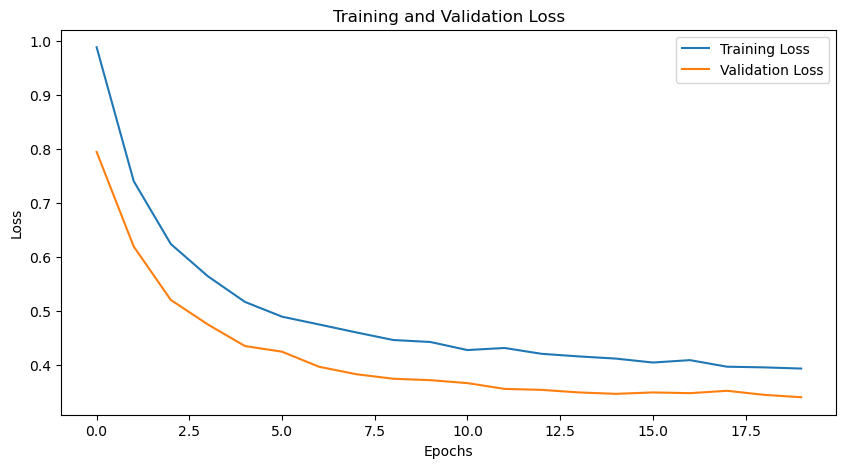

Model saved to clip_segmentation.pth


In [68]:
# Create CLIP-based segmentation model
clip_segmentation = CLIPGuidedSegmentation(num_classes=3).to(device)

# Train CLIP segmentation model
print("Training CLIP-based segmentation model...")
num_epochs = 20  # Adjust as needed
cat_weight = 2.1
clip_segmentation = train_clip_segmentation(clip_segmentation, train_loader, val_loader, 
                                          num_epochs=num_epochs, cat_weight=cat_weight, device=device)

# Save the trained model
torch.save(clip_segmentation.state_dict(), 'clip_segmentation.pth')
print("Model saved to clip_segmentation.pth")

In [69]:
def evaluate_clip_segmentation(model, dataloader, device):
    """
    Evaluate the CLIP-based segmentation model.
    
    Args:
        model: CLIP-based segmentation model
        dataloader: DataLoader for evaluation data
        device: Device to evaluate on
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    
    # Initialize metrics
    correct = 0
    total = 0
    
    # Initialize IoU metrics - one for each class
    num_classes = 3  # background (0), cat (1), dog (2)
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Calculate accuracy (ignoring white pixels with value 255)
            mask = (masks != 255)
            correct += (predicted[mask] == masks[mask]).sum().item()
            total += mask.sum().item()
            
            # Calculate IoU for each class
            for cls in range(num_classes):
                pred_cls = (predicted == cls) & mask
                true_cls = (masks == cls) & mask
                
                # Intersection and union
                intersection[cls] += (pred_cls & true_cls).sum().item()
                union[cls] += (pred_cls | true_cls).sum().item()
    
    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    
    # Calculate IoU for each class
    class_names = ["background", "cat", "dog"]
    class_ious = []
    
    for cls in range(num_classes):
        iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
        class_ious.append(iou)
        print(f"IoU for {class_names[cls]}: {iou:.4f}")
    
    # Calculate mean IoU
    mean_iou = sum(class_ious) / len(class_ious)
    
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    
    return {
        "pixel_accuracy": accuracy,
        "class_ious": {class_names[i]: class_ious[i] for i in range(num_classes)},
        "mean_iou": mean_iou
    }

# Evaluate model on validation set
print("\nEvaluating CLIP-based segmentation model on validation set:")
val_results = evaluate_clip_segmentation(clip_segmentation, val_loader, device)


Evaluating CLIP-based segmentation model on validation set:


Evaluating: 100%|██████████| 46/46 [00:04<00:00,  9.66it/s]

IoU for background: 0.7948
IoU for cat: 0.6458
IoU for dog: 0.6380
Pixel Accuracy: 0.8495
Mean IoU: 0.6929


In [72]:
def visualize_clip_segmentation_results(model, dataloader, device, num_samples=3):
    """
    Visualize the CLIP-guided segmentation model predictions.
    
    Args:
        model: CLIP-guided segmentation model
        dataloader: DataLoader for visualization data
        device: Device to visualize on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of samples
    dataiter = iter(dataloader)
    images, masks = next(dataiter)
    
    # Make sure we don't visualize more than what's available
    num_samples = min(num_samples, images.size(0))
    
    # Class colors for visualization
    colors = torch.tensor([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=torch.uint8)
    
    with torch.no_grad():
        # Get predictions
        outputs = model(images[:num_samples].to(device))
        _, predicted = torch.max(outputs, 1)
        
        # Create visualization
        fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for i in range(num_samples):
            # Original image
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axs[i, 0].imshow(img)
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')
            
            # Ground truth mask
            mask = masks[i].cpu().numpy()
            mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                mask_rgb[mask == j] = colors[j].numpy()
            # Make ignored regions white
            mask_rgb[mask == 255] = [255, 255, 255]
            
            axs[i, 1].imshow(mask_rgb)
            axs[i, 1].set_title('Ground Truth Mask')
            axs[i, 1].axis('off')
            
            # Predicted mask
            pred = predicted[i].cpu().numpy()
            pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                pred_rgb[pred == j] = colors[j].numpy()
            
            # Also make ignored regions white in prediction visualization
            pred_rgb[mask == 255] = [255, 255, 255]
            axs[i, 2].imshow(pred_rgb)
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()


Visualizing CLIP-based segmentation results on validation set:


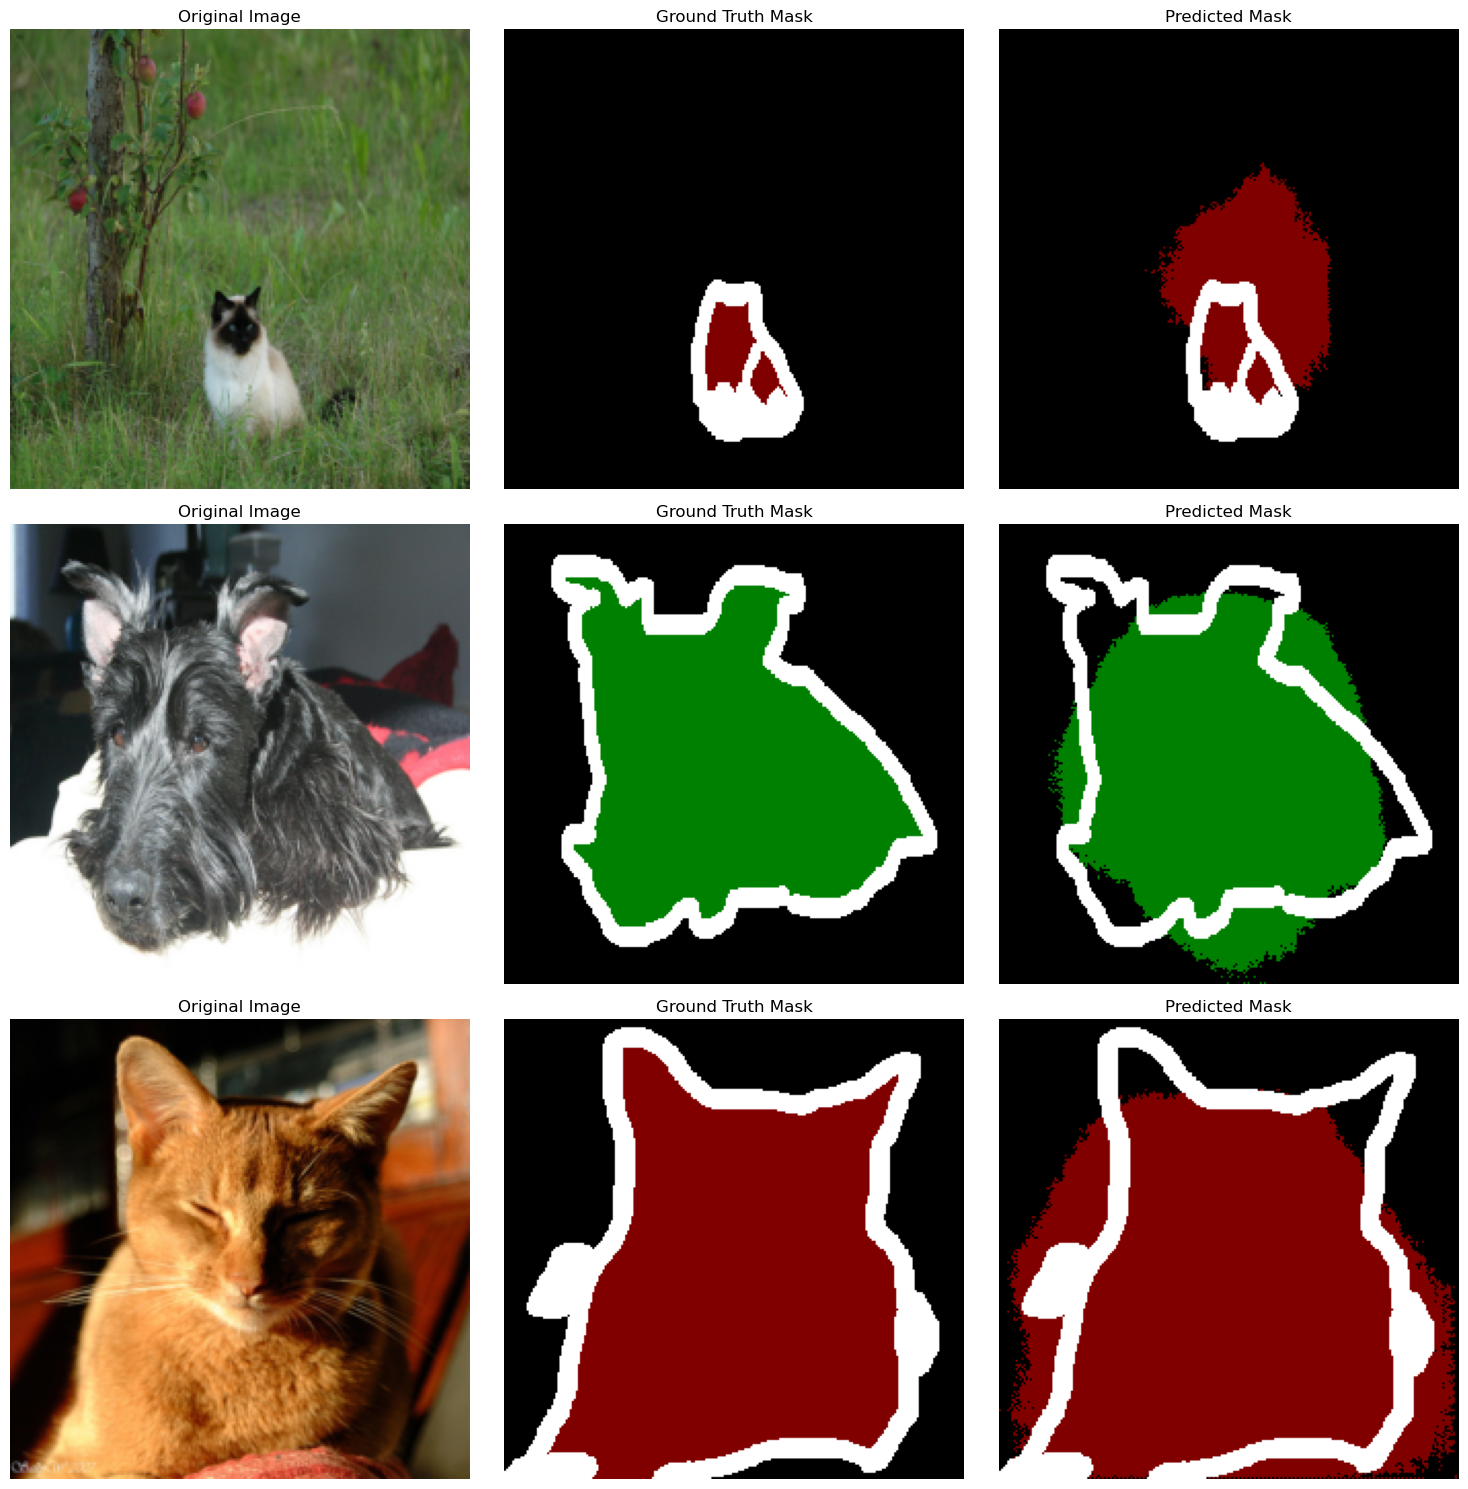

In [74]:
# Visualize results
print("\nVisualizing CLIP-based segmentation results on validation set:")
visualize_clip_segmentation_results(clip_segmentation, val_loader, device, num_samples=3)